In [2]:
# Paso 1: Cargar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report


In [3]:
# Paso 2: Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')


## 1. Valoración del Modelo con umbral 5

In [4]:
# Consideramos un umbral de 5 para el decile_score para predecir si la persona reincidirá o no
df_compas_2y['compas_prediction'] = df_compas_2y['decile_score'] >= 5

# Extraer las predicciones y el valor real (two_year_recid indica la reincidencia real)
y_true = df_compas_2y['two_year_recid'].astype(int)
y_pred = df_compas_2y['compas_prediction'].astype(int)

# Calcular la matriz de confusión y las métricas
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, output_dict=True)

# Imprimir los resultados
print("Matriz de confusión:", conf_matrix)
print("Reporte de clasificación:", class_report)


Matriz de confusión: [[2681 1282]
 [1216 2035]]
Reporte de clasificación: {'0': {'precision': 0.6879651013600205, 'recall': 0.6765076961897553, 'f1-score': 0.6821882951653945, 'support': 3963}, '1': {'precision': 0.6135061802833887, 'recall': 0.6259612426945556, 'f1-score': 0.6196711327649209, 'support': 3251}, 'accuracy': 0.6537288605489326, 'macro avg': {'precision': 0.6507356408217047, 'recall': 0.6512344694421555, 'f1-score': 0.6509297139651578, 'support': 7214}, 'weighted avg': {'precision': 0.6544100760730605, 'recall': 0.6537288605489326, 'f1-score': 0.6540148414692565, 'support': 7214}}


In [5]:
# Preparar la matriz de confusión en un DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual No Reincide', 'Actual Reincide'], 
                              columns=['Predicho No Reincide', 'Predicho Reincide'])

# Preparar el reporte de clasificación en un DataFrame
classification_report_df = pd.DataFrame(class_report).transpose()

# Mostrar los resultados en formato tabular
print("Matriz de Confusión:")
print(conf_matrix_df)

print("\nReporte de Clasificación:")
print(classification_report_df)

Matriz de Confusión:
                    Predicho No Reincide  Predicho Reincide
Actual No Reincide                  2681               1282
Actual Reincide                     1216               2035

Reporte de Clasificación:
              precision    recall  f1-score      support
0              0.687965  0.676508  0.682188  3963.000000
1              0.613506  0.625961  0.619671  3251.000000
accuracy       0.653729  0.653729  0.653729     0.653729
macro avg      0.650736  0.651234  0.650930  7214.000000
weighted avg   0.654410  0.653729  0.654015  7214.000000


### - Interpretación del Reporte de Clasificación:
Fila 0 (No Reincidentes):
Precision (0.69): El 69% de las personas predichas como "No reincidentes" efectivamente no reincidieron.

Recall (0.68): El 68% de las personas que realmente no reincidieron fueron correctamente identificadas como "No reincidentes".

F1-Score (0.68): Este valor balancea la precisión y el recall para no reincidentes.

Fila 1 (Reincidentes):
Precision (0.61): El 61% de las personas predichas como reincidentes realmente reincidieron.

Recall (0.63): El 63% de las personas que realmente reincidieron fueron correctamente identificadas como reincidentes.

F1-Score (0.62): Este valor balancea la precisión y el recall para reincidentes.
Fila accuracy (Exactitud):
Accuracy (0.65): El 65% de todas las predicciones (tanto positivas como negativas) fueron correctas.

Fila macro avg (Promedio Macro):
Macro Avg: Promedio simple de la precisión, recall y F1-score para las clases 0 y 1. No toma en cuenta el desbalanceo entre las clases.
En este caso, como las dos clases no están perfectamente balanceadas, este promedio puede ser menos representativo del rendimiento global.

Fila weighted avg (Promedio Ponderado):
Weighted Avg: Promedio ponderado de las métricas, teniendo en cuenta el número de instancias de cada clase. Es una métrica más representativa cuando las clases están desbalanceadas, ya que le da más peso a las clases con más ocurrencias.
Aquí, las clases tienen soporte relativamente similar, pero es común en conjuntos desbalanceados que esta métrica sea preferida sobre el promedio macro.

Interpretación general:
El modelo de COMPAS tiene una precisión moderada para predecir tanto los reincidentes como los no reincidentes, pero la tasa de falsos positivos y falsos negativos es considerable, lo que indica limitaciones en su capacidad para identificar correctamente quién reincidirá y quién no.

La precisión y el recall para los reincidentes son menores que para los no reincidentes, lo que indica que es más probable que el modelo falle al predecir correctamente los reincidentes.

Conclusión:
El modelo COMPAS tiene un rendimiento razonable, pero existen importantes diferencias en las tasas de error entre las dos clases (especialmente en la predicción de reincidentes). Esto puede tener implicaciones serias cuando se usa en decisiones relacionadas con la justicia penal, ya que un número considerable de personas puede ser falsamente clasificada como reincidente o viceversa.

## 2. Valoración del Modelo con umbrales 4, 6 y 8

In [6]:
# Vamos a probar los umbrales 4, 6 y 8 y calcular las métricas para cada uno

thresholds = [4, 6, 8]
results = []

for threshold in thresholds:
    # Actualizar las predicciones según el umbral actual
    df_compas_2y[f'compas_prediction_{threshold}'] = df_compas_2y['decile_score'] >= threshold
    y_pred_threshold = df_compas_2y[f'compas_prediction_{threshold}'].astype(int)
    
    # Calcular las métricas
    class_report_threshold = classification_report(df_compas_2y['two_year_recid'].astype(int), y_pred_threshold, output_dict=True)
    
    # Guardar los resultados clave (Precision, Recall, F1-Score, Accuracy)
    results.append({
        'Threshold': threshold,
        'Precision (No Reincide)': class_report_threshold['0']['precision'],
        'Recall (No Reincide)': class_report_threshold['0']['recall'],
        'F1-Score (No Reincide)': class_report_threshold['0']['f1-score'],
        'Precision (Reincide)': class_report_threshold['1']['precision'],
        'Recall (Reincide)': class_report_threshold['1']['recall'],
        'F1-Score (Reincide)': class_report_threshold['1']['f1-score'],
        'Accuracy': class_report_threshold['accuracy']
    })

# Convertir los resultados a DataFrame
df_threshold_results_v2 = pd.DataFrame(results)

# Mostrar los resultados
print("Resultados por Umbral (4, 6, 8):")
print(df_threshold_results_v2)


Resultados por Umbral (4, 6, 8):
   Threshold  Precision (No Reincide)  Recall (No Reincide)  \
0          4                 0.718031              0.566742   
1          6                 0.663172              0.766086   
2          8                 0.612803              0.898562   

   F1-Score (No Reincide)  Precision (Reincide)  Recall (Reincide)  \
0                0.633479              0.579785           0.728699   
1                0.710924              0.648331           0.525684   
2                0.728668              0.713471           0.307905   

   F1-Score (Reincide)  Accuracy  
0             0.645768  0.639728  
1             0.580601  0.657749  
2             0.430168  0.632381  


### Interpretación comparativa umbrales 4, 6 y 8

Umbral 4:
Alta detección de reincidentes (recall del 72.87%), pero con menor precisión (57.98%).
F1-Score para reincidentes: 64.58%.
Exactitud general: 63.97%.

Umbral 6:
Mayor equilibrio entre precisión y recall. El recall baja a 52.57%, pero la precisión aumenta a 64.83%.
F1-Score para reincidentes: 58.06%.
Exactitud: 65.77%.
Umbral 8:

Muy alta precisión para los reincidentes (71.35%) a costa de una fuerte caída en recall (30.79%).
F1-Score para reincidentes: 43.02%.
Exactitud general: 63.24%.

El umbral 6 parece ofrecer un buen balance entre precisión y recall, mientras que los umbrales 4 y 8 enfatizan recall o precisión, respectivamente.

### Comparativa umbrales 4, 6 y 8 en cuanto a otros KPIs: AUC, ROC y F1-Score

In [7]:
# Generar predicciones para los umbrales 4, 6 y 8
thresholds = [4, 6, 8]
for threshold in thresholds:
    df_compas_2y[f'compas_prediction_{threshold}'] = df_compas_2y['decile_score'] >= threshold

# Comparación general para AUC-ROC y F1-Score en los umbrales 4, 6 y 8
comparison_results = []

for threshold in thresholds:
    # Generar predicciones según el umbral actual
    y_pred_threshold = df_compas_2y[f'compas_prediction_{threshold}'].astype(int)
    
    # Calcular F1-Score para reincidentes
    class_report_threshold = classification_report(y_true, y_pred_threshold, output_dict=True)
    f1_score_value = class_report_threshold['1']['f1-score']  # F1-Score para reincidentes
    
    # Calcular AUC-ROC
    y_pred_prob = df_compas_2y['decile_score'] / 10  # Probabilidad basada en el puntaje COMPAS (0-10)
    auc_roc_value = roc_auc_score(y_true, y_pred_prob)
    
    # Guardar los resultados
    comparison_results.append({
        'Threshold': threshold,
        'F1-Score (Reincidentes)': f1_score_value,
        'AUC-ROC': auc_roc_value
    })

# Convertir los resultados en un DataFrame para su visualización
df_comparison_results = pd.DataFrame(comparison_results)

# Mostrar los resultados en formato tabular
print(df_comparison_results)


   Threshold  F1-Score (Reincidentes)   AUC-ROC
0          4                 0.645768  0.702166
1          6                 0.580601  0.702166
2          8                 0.430168  0.702166


### Curvas ROC AUC si utilizamos Probabilidades continuas (puntaje COMPAS escalado (decile_score / 10) como probabilidades continuas para calcular la curva ROC)

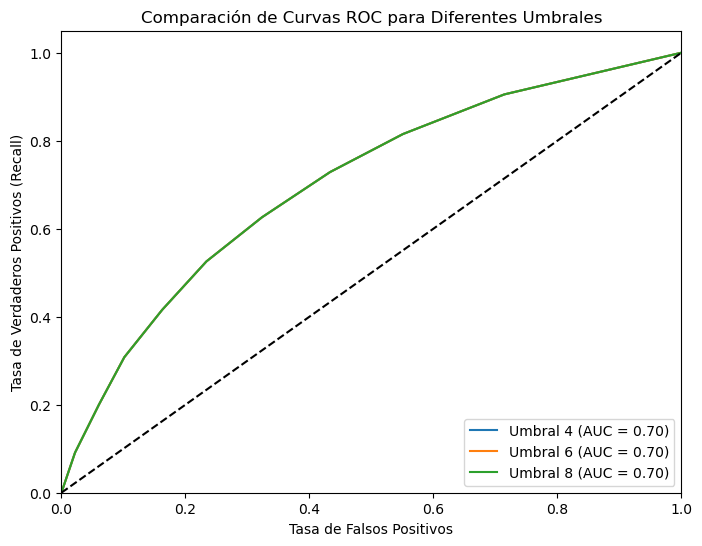

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Graficar la curva ROC utilizando probabilidades continuas
plt.figure(figsize=(8, 6))

# Calcular las probabilidades continuas (decile_score/10)
y_pred_prob = df_compas_2y['decile_score'] / 10

# Generar la curva ROC y el AUC-ROC para cada umbral
for threshold in thresholds:
    # Usar las probabilidades continuas para la curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Umbral {threshold} (AUC = {roc_auc:.2f})')

# Graficar la línea base
plt.plot([0, 1], [0, 1], 'k--')

# Etiquetas y título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Comparación de Curvas ROC para Diferentes Umbrales')
plt.legend(loc="lower right")
plt.show()

### Curvas ROC AUC si utilizamos predicciones binarias (0,1)

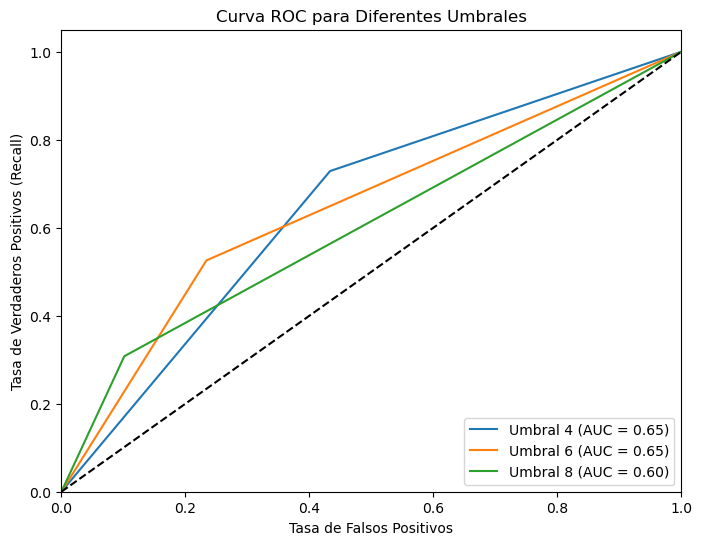

In [9]:
# Graficar la curva ROC para los umbrales 4, 6 y 8
plt.figure(figsize=(8, 6))

# Generar la curva ROC para cada umbral
for threshold in thresholds:
    y_pred_threshold = df_compas_2y[f'compas_prediction_{threshold}'].astype(int)
    
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_threshold)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Umbral {threshold} (AUC = {roc_auc:.2f})')

# Graficar la línea base
plt.plot([0, 1], [0, 1], 'k--')

# Etiquetas y título
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC para Diferentes Umbrales')
plt.legend(loc="lower right")
plt.show()

### Interpretación del AUC y Selección del umbral

En nuestro caso, dado que el AUC-ROC se mantiene alrededor de 0.70, significa que el modelo tiene un poder discriminatorio moderado, independientemente del umbral que utilicemos.

Si preocupa más evitar falsos positivos (por ejemplo, etiquetar incorrectamente a alguien como reincidente), un umbral más alto (como 8) puede ser preferible.
Si es preferible maximizar el recall (es decir, capturar todos los reincidentes), incluso si aumenta la tasa de falsos positivos, un umbral más bajo (como 4) puede ser más apropiado.
Umbral 6 podría ser un compromiso razonable entre ambos extremos

## 3. ¿Cómo afecta al sesgo racial? Análisis del sesgo racial

Impacto del Umbral en el Sesgo Racial
El sesgo racial en un modelo como COMPAS se manifiesta cuando las tasas de error (falsos positivos o falsos negativos) difieren entre grupos raciales, lo que puede llevar a la toma de decisiones injustas.

Al ajustar el umbral:

Umbral bajo (por ejemplo, 4):
Mayor recall para los reincidentes significa que se identifican más personas como reincidentes, pero también aumenta la probabilidad de falsos positivos.
Impacto en el sesgo racial: Los grupos que históricamente reciben puntajes más altos en COMPAS, como los afroamericanos, podrían verse afectados con más falsos positivos, es decir, podrían ser clasificados como reincidentes cuando no lo son, lo que agrava el sesgo racial.

Umbral alto (por ejemplo, 8):
Mayor precisión para los reincidentes significa que el modelo es más conservador al etiquetar a alguien como reincidente, pero más personas que realmente reinciden podrían ser clasificadas como no reincidentes (más falsos negativos).

Impacto en el sesgo racial: Si el umbral se aumenta demasiado, los afroamericanos u otros grupos históricamente sobrepredichos podrían ver una disminución en la cantidad de falsos positivos, pero a expensas de una mayor tasa de falsos negativos (personas que reinciden pero son clasificadas como no reincidentes).

Para determinar cómo afecta esto al sesgo racial, podemos calcular métricas como precisión, recall y tasa de falsos positivos para cada grupo racial en función de diferentes umbrales.

### Afectación al Sesgo Racial

In [10]:
# Vamos a analizar el impacto en el sesgo racial con los umbrales 4, 6 y 8
racial_groups = df_compas_2y['race'].unique()
thresholds = [4, 6, 8]
racial_bias_results = []

# Calcular métricas por grupo racial y por umbral
for threshold in thresholds:
    for group in racial_groups:
        y_true_group = df_compas_2y[df_compas_2y['race'] == group]['two_year_recid'].astype(int)
        y_pred_group = df_compas_2y[df_compas_2y['race'] == group][f'compas_prediction_{threshold}'].astype(int)
        
        # Calcular las métricas
        report = classification_report(y_true_group, y_pred_group, output_dict=True)
        
        # Guardar los resultados clave (Precision, Recall, F1-Score, Accuracy) por raza y umbral
        racial_bias_results.append({
            'Threshold': threshold,
            'Race': group,
            'Precision (No Reincide)': report['0']['precision'],
            'Recall (No Reincide)': report['0']['recall'],
            'F1-Score (No Reincide)': report['0']['f1-score'],
            'Precision (Reincide)': report['1']['precision'],
            'Recall (Reincide)': report['1']['recall'],
            'F1-Score (Reincide)': report['1']['f1-score'],
            'Accuracy': report['accuracy']
        })

# Convertir los resultados a DataFrame
df_racial_bias_results = pd.DataFrame(racial_bias_results)

# Mostrar los resultados en formato tabular
print("Análisis de Sesgo Racial con Diferentes Umbrales (4, 6, 8):")
print(df_racial_bias_results)


Análisis de Sesgo Racial con Diferentes Umbrales (4, 6, 8):
    Threshold              Race  Precision (No Reincide)  \
0           4             Other                 0.742063   
1           4  African-American                 0.687775   
2           4         Caucasian                 0.735361   
3           4          Hispanic                 0.718987   
4           4   Native American                 1.000000   
5           4             Asian                 0.875000   
6           6             Other                 0.687500   
7           6  African-American                 0.624801   
8           6         Caucasian                 0.689299   
9           6          Hispanic                 0.685371   
10          6   Native American                 0.833333   
11          6             Asian                 0.840000   
12          8             Other                 0.678063   
13          8  African-American                 0.565706   
14          8         Caucasian         

### Interpretación del impacto en el sesgo racial:

Raza: Afroamericanos: Tienen una tasa de recall significativamente mayor para reincidentes (umbral 4: 81.33%), lo que indica que más afroamericanos son clasificados como reincidentes en este umbral. Sin embargo, la precisión es más baja, lo que puede significar una mayor tasa de falsos positivos.

Raza: Caucásicos: En general, muestran un balance más equitativo entre precisión y recall, lo que sugiere que los efectos del sesgo podrían ser menores en comparación con los afroamericanos.

Otros grupos (Hispanos, Nativos Americanos): Estos grupos tienen menos datos, por lo que las métricas pueden ser menos estables. Los nativos americanos muestran una precisión perfecta en algunos umbrales, pero esto puede deberse al tamaño reducido de la muestra.

Este análisis sugiere que el umbral más bajo (4) favorece el recall para ciertos grupos, lo que puede exacerbar los falsos positivos en afroamericanos. Los umbrales más altos (como 8) reducen los falsos positivos pero también afectan negativamente el recall, es decir, se podrían estar "dejando pasar" reincidentes.

### Visualización de los resultados (Por raza)

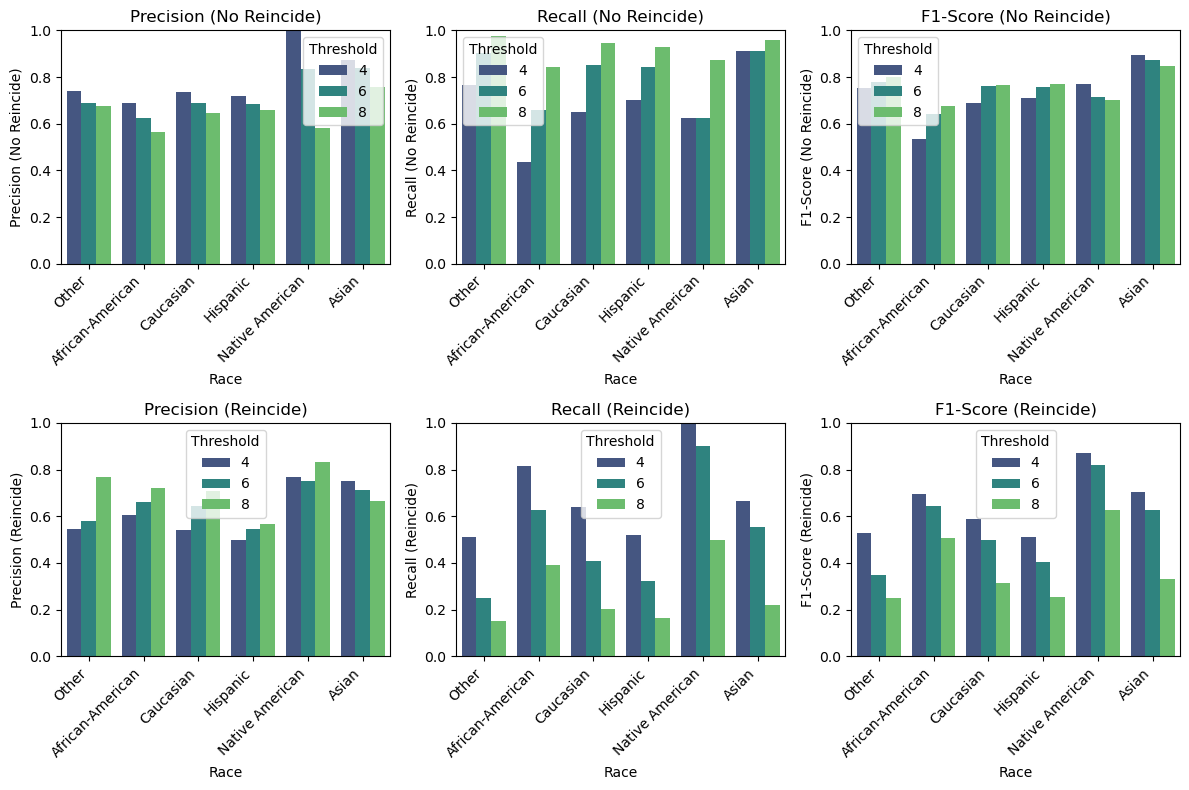

In [11]:
# Asegurarnos de que la columna 'Threshold' sea de tipo cadena para evitar problemas en la leyenda
df_racial_bias_results['Threshold'] = df_racial_bias_results['Threshold'].astype(str)

# Configurar el tamaño de los gráficos
plt.figure(figsize=(12, 8))

# Crear subplots para Precision, Recall y F1-Score
metrics_to_plot = ['Precision (No Reincide)', 'Recall (No Reincide)', 'F1-Score (No Reincide)', 
                   'Precision (Reincide)', 'Recall (Reincide)', 'F1-Score (Reincide)']

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Race', y=metric, hue='Threshold', data=df_racial_bias_results, palette='viridis')
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 3. ¿Cómo afecta al sesgo por género? Análisis del sesgo por género

In [12]:
# Generar predicciones para los umbrales 4, 6 y 8
thresholds = [4, 6, 8]
for threshold in thresholds:
    df_compas_2y[f'compas_prediction_{threshold}'] = df_compas_2y['decile_score'] >= threshold

# Análisis por sexo: AUC-ROC, F1-Score y KPIs de la matriz de confusión para los umbrales 4, 6 y 8
sex_groups = df_compas_2y['sex'].unique()
sex_analysis_results = []

for threshold in thresholds:
    for group in sex_groups:
        # Filtrar por sexo
        y_true_group = df_compas_2y[df_compas_2y['sex'] == group]['two_year_recid'].astype(int)
        y_pred_group = df_compas_2y[df_compas_2y['sex'] == group][f'compas_prediction_{threshold}'].astype(int)
        
        # Calcular KPIs de la matriz de confusión (Precisión, Recall, F1-Score)
        class_report_group = classification_report(y_true_group, y_pred_group, output_dict=True)
        
        # F1-Score para reincidentes
        f1_score_value = class_report_group['1']['f1-score']
        
        # Calcular AUC-ROC
        y_pred_prob_group = df_compas_2y[df_compas_2y['sex'] == group]['decile_score'] / 10
        auc_roc_value_group = roc_auc_score(y_true_group, y_pred_prob_group)
        
        # Guardar los resultados de KPIs y AUC-ROC
        sex_analysis_results.append({
            'Threshold': threshold,
            'Sex': group,
            'Precision (No Reincide)': class_report_group['0']['precision'],
            'Recall (No Reincide)': class_report_group['0']['recall'],
            'F1-Score (No Reincide)': class_report_group['0']['f1-score'],
            'Precision (Reincide)': class_report_group['1']['precision'],
            'Recall (Reincide)': class_report_group['1']['recall'],
            'F1-Score (Reincidentes)': f1_score_value,
            'AUC-ROC': auc_roc_value_group
        })

# Convertir los resultados a DataFrame para su visualización
df_sex_analysis_results = pd.DataFrame(sex_analysis_results)

# Mostrar los resultados en formato tabular
print(df_sex_analysis_results)


   Threshold     Sex  Precision (No Reincide)  Recall (No Reincide)  \
0          4    Male                 0.700162              0.563601   
1          4  Female                 0.784848              0.577480   
2          6    Male                 0.644671              0.761579   
3          6  Female                 0.733264              0.781494   
4          8    Male                 0.594225              0.892694   
5          8  Female                 0.683817              0.918618   

   F1-Score (No Reincide)  Precision (Reincide)  Recall (Reincide)  \
0                0.624503              0.600716           0.731202   
1                0.665382              0.484354           0.714859   
2                0.698266              0.667274           0.532510   
3                0.756611              0.553531           0.487952   
4                0.713504              0.728772           0.321104   
5                0.784015              0.615789           0.234940   

   F1-Score

### Visualización de Resultados

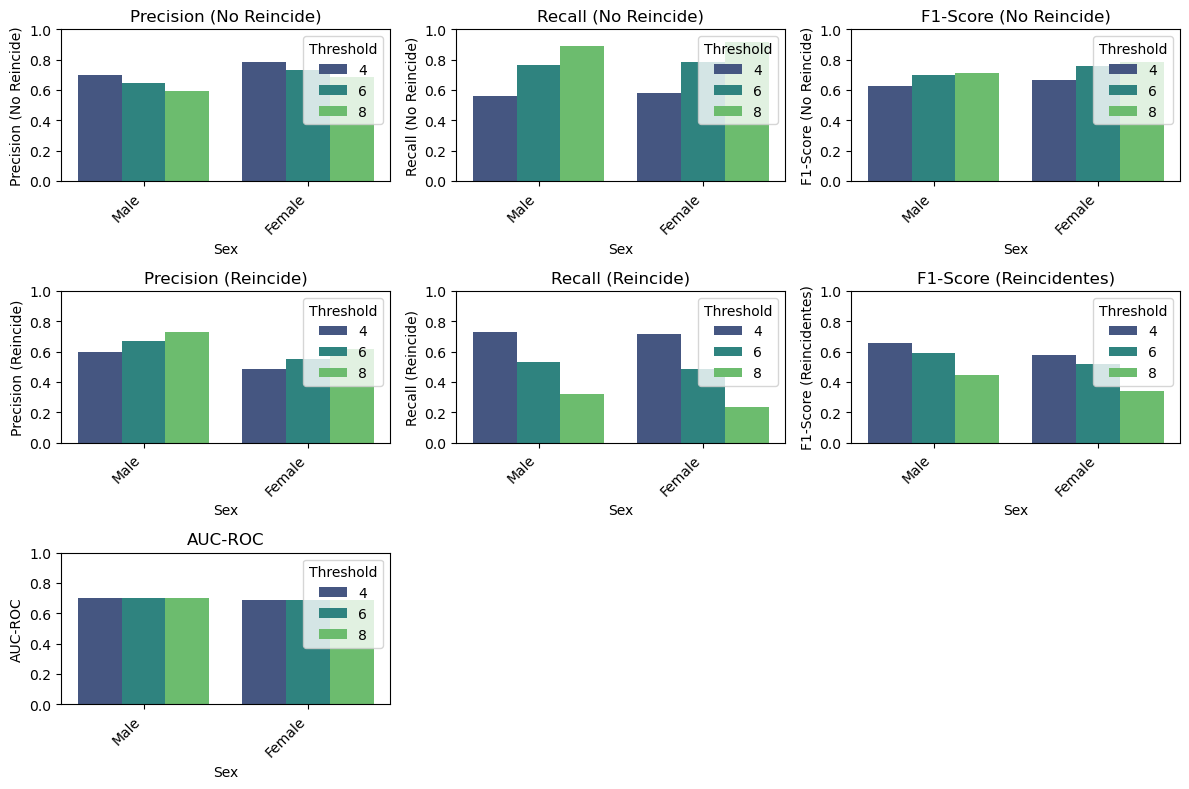

In [13]:
# Asegurarnos de que la columna 'Threshold' sea de tipo cadena
df_sex_analysis_results['Threshold'] = df_sex_analysis_results['Threshold'].astype(str)

# Configurar el tamaño de los gráficos
plt.figure(figsize=(12, 8))

# Crear subplots para Precision, Recall, F1-Score y AUC-ROC
metrics_to_plot = ['Precision (No Reincide)', 'Recall (No Reincide)', 'F1-Score (No Reincide)', 
                   'Precision (Reincide)', 'Recall (Reincide)', 'F1-Score (Reincidentes)', 'AUC-ROC']

# Crear gráficos de barras para cada métrica
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x='Sex', y=metric, hue='Threshold', data=df_sex_analysis_results, palette='viridis')
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Interpretación General
1. Umbral 4:
Hombres:
Recall puede ser mayor, lo que significa que el modelo está capturando a más reincidentes entre los hombres, pero esto puede aumentar los falsos positivos.
Precisión podría ser ligeramente menor, indicando que el modelo predice más reincidentes de lo que realmente hay, lo que lleva a clasificaciones incorrectas.
Mujeres:
F1-Score: Si el F1-Score es similar o más bajo que el de los hombres, podría indicar que el modelo tiene un rendimiento algo inferior para predecir reincidentes entre las mujeres en este umbral.
AUC-ROC: Puede que se mantenga estable, lo que indica que el modelo tiene un rendimiento moderado tanto para hombres como para mujeres en términos de capacidad de discriminación.

2. Umbral 6:
Hombres y Mujeres:
Equilibrio entre precisión y recall: Este umbral podría ofrecer el mejor equilibrio entre precisión y recall, lo que significa que el modelo está haciendo menos predicciones erróneas, tanto de reincidentes como de no reincidentes.
F1-Score: El F1-Score en este caso suele ser el más equilibrado, ya que se encuentra en un punto medio entre maximizar el recall y minimizar los falsos positivos.
AUC-ROC: A medida que sube el umbral, puede que el AUC-ROC no varíe significativamente, ya que estamos utilizando las mismas probabilidades continuas.

3. Umbral 8:
Hombres:
Precisión: Es probable que sea mayor que en los umbrales anteriores, lo que significa que el modelo está siendo más conservador al predecir reincidentes (menos falsos positivos).
Recall: Puede disminuir, ya que el modelo está capturando menos reincidentes verdaderos, lo que aumenta los falsos negativos.
Mujeres:
Recall: Si el recall disminuye mucho, el modelo podría no estar identificando a suficientes reincidentes entre las mujeres.
AUC-ROC: No debería variar mucho, pero puede mostrar un rendimiento menor en general si el modelo se vuelve demasiado conservador.

Resumen de cómo afectan los umbrales:
Umbral más bajo (4): Favorece un mayor recall (más reincidentes capturados), pero a costa de más falsos positivos (especialmente para hombres).

Umbral medio (6): Ofrece un mejor equilibrio entre precisión y recall, probablemente el más justo entre sexos.

Umbral más alto (8): Favorece la precisión (menos falsos positivos), pero con un recall más bajo (menos reincidentes capturados).

## Generación de un archivo con todos los datos para poder utilizarlo en un Dashboard

In [14]:
# Generar predicciones para los umbrales 4, 6 y 8
thresholds = [4, 6, 8]
for threshold in thresholds:
    df_compas_2y[f'compas_prediction_{threshold}'] = df_compas_2y['decile_score'] >= threshold

# 1. Generar el DataFrame `df_comparison_results` (Comparación general AUC-ROC y F1-Score por umbral)
comparison_results = []
for threshold in thresholds:
    y_pred_threshold = df_compas_2y[f'compas_prediction_{threshold}'].astype(int)
    class_report_threshold = classification_report(df_compas_2y['two_year_recid'], y_pred_threshold, output_dict=True)
    f1_score_value = class_report_threshold['1']['f1-score']
    y_pred_prob = df_compas_2y['decile_score'] / 10
    auc_roc_value = roc_auc_score(df_compas_2y['two_year_recid'], y_pred_prob)
    comparison_results.append({
        'Threshold': threshold,
        'Metric': 'F1-Score',
        'Value': f1_score_value,
        'Category': 'General'
    })
    comparison_results.append({
        'Threshold': threshold,
        'Metric': 'AUC-ROC',
        'Value': auc_roc_value,
        'Category': 'General'
    })
df_comparison_results = pd.DataFrame(comparison_results)

# 2. Generar el DataFrame `df_racial_auc_f1_results` (AUC-ROC y F1-Score por raza y umbral)
racial_groups = df_compas_2y['race'].unique()
racial_auc_f1_results = []
for threshold in thresholds:
    for group in racial_groups:
        y_true_group = df_compas_2y[df_compas_2y['race'] == group]['two_year_recid'].astype(int)
        y_pred_group = df_compas_2y[df_compas_2y['race'] == group][f'compas_prediction_{threshold}'].astype(int)
        class_report_group = classification_report(y_true_group, y_pred_group, output_dict=True)
        f1_score_value = class_report_group['1']['f1-score']
        y_pred_prob_group = df_compas_2y[df_compas_2y['race'] == group]['decile_score'] / 10
        auc_roc_value_group = roc_auc_score(y_true_group, y_pred_prob_group)
        racial_auc_f1_results.append({
            'Threshold': threshold,
            'Metric': 'F1-Score',
            'Value': f1_score_value,
            'Category': group
        })
        racial_auc_f1_results.append({
            'Threshold': threshold,
            'Metric': 'AUC-ROC',
            'Value': auc_roc_value_group,
            'Category': group
        })
df_racial_auc_f1_results = pd.DataFrame(racial_auc_f1_results)

# 3. Generar el DataFrame `df_sex_analysis_results` (AUC-ROC y F1-Score por sexo y umbral)
sex_groups = df_compas_2y['sex'].unique()
sex_auc_f1_results = []
for threshold in thresholds:
    for group in sex_groups:
        y_true_group = df_compas_2y[df_compas_2y['sex'] == group]['two_year_recid'].astype(int)
        y_pred_group = df_compas_2y[df_compas_2y['sex'] == group][f'compas_prediction_{threshold}'].astype(int)
        class_report_group = classification_report(y_true_group, y_pred_group, output_dict=True)
        f1_score_value = class_report_group['1']['f1-score']
        y_pred_prob_group = df_compas_2y[df_compas_2y['sex'] == group]['decile_score'] / 10
        auc_roc_value_group = roc_auc_score(y_true_group, y_pred_prob_group)
        sex_auc_f1_results.append({
            'Threshold': threshold,
            'Metric': 'F1-Score',
            'Value': f1_score_value,
            'Category': group
        })
        sex_auc_f1_results.append({
            'Threshold': threshold,
            'Metric': 'AUC-ROC',
            'Value': auc_roc_value_group,
            'Category': group
        })
df_sex_analysis_results = pd.DataFrame(sex_auc_f1_results)

# 4. Concatenar todos los DataFrames en uno solo
df_final = pd.concat([df_comparison_results, df_racial_auc_f1_results, df_sex_analysis_results], axis=0, ignore_index=True)

'''
# 5. Guardar el DataFrame consolidado en un archivo CSV
file_path = "/mnt/data/compas_analysis_results_real_values.csv"
df_final.to_csv(file_path, index=False)

# Confirmar que el archivo se ha generado correctamente
file_path
'''

'\n# 5. Guardar el DataFrame consolidado en un archivo CSV\nfile_path = "/mnt/data/compas_analysis_results_real_values.csv"\ndf_final.to_csv(file_path, index=False)\n\n# Confirmar que el archivo se ha generado correctamente\nfile_path\n'

In [15]:
df_final.head(40)

,Threshold,Metric,Value,Category
0,4,F1-Score,0.645768,General
1,4,AUC-ROC,0.702166,General
2,6,F1-Score,0.580601,General
3,6,AUC-ROC,0.702166,General
4,8,F1-Score,0.430168,General
5,8,AUC-ROC,0.702166,General
6,4,F1-Score,0.527132,Other
7,4,AUC-ROC,0.695535,Other
8,4,F1-Score,0.693274,African-American
9,4,AUC-ROC,0.691834,African-American
